In [1]:
data = read.csv('hw9t3v1.txt',sep = '',header = FALSE)

In [2]:
head(data)

V1,V2,V3,V4,V5,V6
1.604,1.164,11.066,0.211,2.267,9.196
0.745,1.174,7.098,0.195,1.852,8.779
1.065,1.277,1.160,0.203,3.649,40.273
1.614,1.489,10.480,0.086,2.783,14.847
1.835,1.200,0.328,0.172,3.340,37.330
1.594,1.700,8.605,0.125,3.053,22.726


In [3]:
n<-400
q<-100

In [17]:
## 75% of the sample size
smp_size <- floor(n)

## set the seed to make your partition reproductible
train_ind <- 1:n

train <- data[train_ind, ]
test <- data[-train_ind, ]

In [18]:
library("ggplot2") # графики
library("sandwich") # оценка Var для гетероскедастичности
library("lmtest") # тест Бройша-Пагана
library("dplyr") # манипуляции с данными

In [22]:
head(train)

V1,V2,V3,V4,V5,V6
1.604,1.164,11.066,0.211,2.267,9.196
0.745,1.174,7.098,0.195,1.852,8.779
1.065,1.277,1.160,0.203,3.649,40.273
1.614,1.489,10.480,0.086,2.783,14.847
1.835,1.200,0.328,0.172,3.340,37.330
1.594,1.700,8.605,0.125,3.053,22.726


проверим модель на гомоскедастичность

In [84]:
model<-lm(V6 ~ V1 + V2 + V3 + V4 + V5, data=train)

In [85]:
summary(model)


Call:
lm(formula = V6 ~ V1 + V2 + V3 + V4 + V5, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.0077 -2.3123 -0.3355  1.4114 28.6273 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -14.8339     1.2326 -12.034  < 2e-16 ***
V1            2.5329     0.3928   6.449 3.30e-10 ***
V2            1.2755     0.3012   4.235 2.85e-05 ***
V3           -1.4240     0.0356 -39.996  < 2e-16 ***
V4            3.8354     5.0188   0.764    0.445    
V5           14.3333     0.1871  76.605  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.409 on 394 degrees of freedom
Multiple R-squared:  0.9506,	Adjusted R-squared:  0.9499 
F-statistic:  1515 on 5 and 394 DF,  p-value: < 2.2e-16


In [86]:
bptest(model) # версия Коэнкера


	studentized Breusch-Pagan test

data:  model
BP = 22.301, df = 5, p-value = 0.0004589


In [87]:
bptest(model, studentize = FALSE) # классика Бройша-Пагана


	Breusch-Pagan test

data:  model
BP = 171.53, df = 5, p-value < 2.2e-16


как видно, есть гетероскедастичность, поэтому будем использовать специальный метод оценки значимости
(на самом деле так надо было делать сразу)

Возможная мультиколлинеарность никого не волнует

In [38]:
library(car)

доверительный интервал с учетом гетероскедастичности

In [88]:
conftable <- coeftest(model, vcov = vcovHC(model))
conftable
ci <- data_frame(estimate = conftable[, 1], 
                 se_hc = conftable[, 2],
                 left_95 = estimate - qnorm(0.975)*se_hc,
                 right_95 = estimate + qnorm(0.975)*se_hc)
ci


t test of coefficients:

              Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) -14.833953   1.778793  -8.3393 1.266e-15 ***
V1            2.532936   0.373030   6.7902 4.138e-11 ***
V2            1.275483   0.300191   4.2489 2.684e-05 ***
V3           -1.423962   0.034741 -40.9875 < 2.2e-16 ***
V4            3.835377   5.183740   0.7399    0.4598    
V5           14.333273   0.442745  32.3736 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


estimate,se_hc,left_95,right_95
-14.833953,1.77879314,-18.3203235,-11.347583
2.532936,0.37303043,1.8018094,3.264062
1.275483,0.30019136,0.6871191,1.863848
-1.423962,0.03474135,-1.4920533,-1.355870
3.835377,5.18374027,-6.3245671,13.995321
14.333273,0.44274516,13.4655080,15.201037


видно, что 0 попадает в интревал только для 4 признака, поэтому его и выкинем как незначимый

In [90]:
model<-lm(V6 ~ V1 + V2 + V3 + V5, data=train)
pred<-as.numeric(predict(model, test))

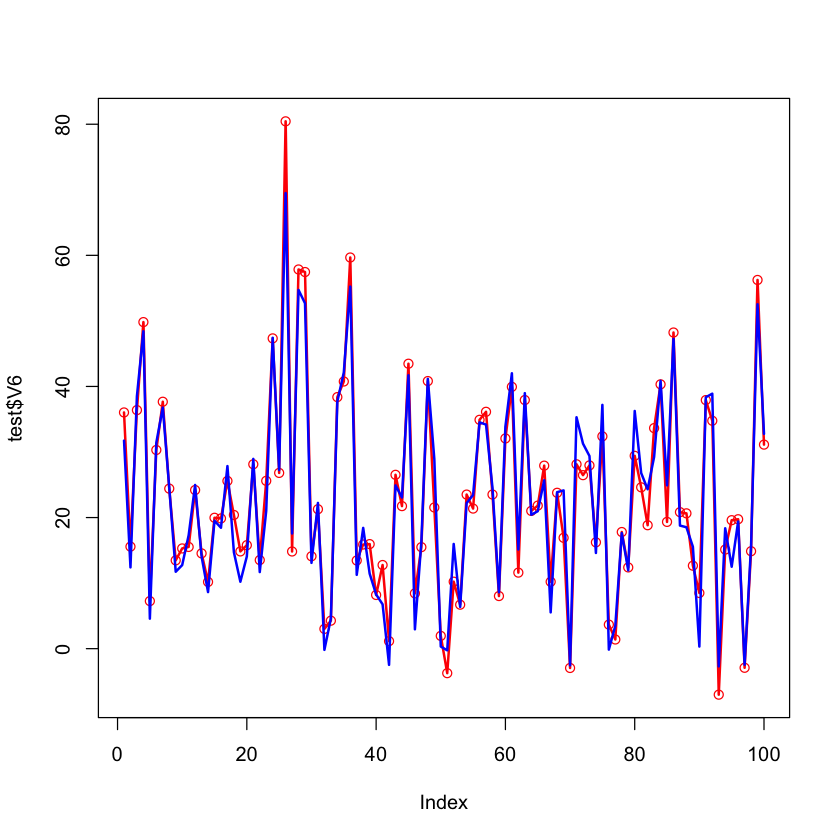

In [109]:
plot(test$V6,col = 'red')

lines(test$V6, col = "red", lwd = 2)
lines(pred, col = "blue", lwd = 2)

In [108]:
mean(abs(pred - test$V6)/((abs(pred) + abs(test$V6))/2))

[1] 0.2499871

smape получился достаточно хорошим